# Neural Network

In this tutorial, we'll create a simple neural network classifier in TensorFlow. The key advantage of this model over the [Linear Classifier](https://github.com/easy-tensorflow/easy-tensorflow/blob/master/3_Neural_Network/Tutorials/1_Neural_Network.ipynb) trained in the previous tutorial is that it can separate data which is __NOT__ linearly separable. We will implement this model for classifying images of hand-written digits from the so-called MNIST data-set.

We assume that you have the basic knowledge over the concept and you are just interested in the __Tensorflow__ implementation of the Neural Nets. If you want to know more about the Neural Nets we suggest you to take [this](https://www.coursera.org/learn/machine-learning) amazing course on machine learning or check out the following tutorials:

 [Neural Networks Part 1: Setting up the Architecture](https://cs231n.github.io/neural-networks-1/)
 
 [Neural Networks Part 2: Setting up the Data and the Loss](https://cs231n.github.io/neural-networks-2/)
 
 [Neural Networks Part 3: Learning and Evaluation](https://cs231n.github.io/neural-networks-3/)

The structure of the neural network that we're going to implement is as follows. Like before, we're using images of handw-ritten digits of the MNIST data which has 10 classes (i.e. digits from 0 to 9). The implemented network has 2 hidden layers: the first one with 200 hidden units (neurons) and the second one (also known as classifier layer) with 10 (number of classes) neurons.

<img src="files/files/nn.png">

___Fig. 1-___ Sample Neural Network architecture with two layers implemented for classifying MNIST digits




## 0. Import the required libraries:
We will start with importing the required Python libraries.

In [1]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 1. Load the MNIST data

For this tutorial we use the MNIST dataset. MNIST is a dataset of handwritten digits. If you are into machine learning, you might have heard of this dataset by now. MNIST is kind of benchmark of datasets for deep learning and is easily accesible through Tensorflow

The dataset contains $55,000$ examples for training, $5,000$ examples for validation and $10,000$ examples for testing. The digits have been size-normalized and centered in a fixed-size image ($28\times28$ pixels) with values from $0$ to $1$. For simplicity, each image has been flattened and converted to a 1-D numpy array of $784$ features ($28\times28$).

<img src="files/files/mnist.png">


If you want to know more about the MNIST dataset you can check __Yann Lecun__'s [website](http://yann.lecun.com/exdb/mnist/).

### 1.1. Data dimension
Here, we specify the dimensions of the images which will be used in several places in the code below. Defining these variables makes it easier (compared with using hard-coded number all throughout the code) to modify them later. Ideally these would be inferred from the data that has been read, but here we will just write the numbers.

It's important to note that in a linear model, we have to flatten the input images into a vector. Here, each of the $28\times28$ images are flattened into a $1\times784$ vector. 

In [2]:
img_h = img_w = 28             # MNIST images are 28x28
img_size_flat = img_h * img_w  # 28x28=784, the total number of pixels
n_classes = 10                 # Number of classes, one class per digit

### 1.2. Helper functions to load the MNIST data

In this section, we'll write the function which automatically loads the MNIST data and returns it in our desired shape and format. If you wanna learn more about loading your data, you may read our __How to Load Your Data in TensorFlow __ tutorial which explains all the available methods to load your own data; no matter how big it is. 

Here, we'll simply write a function (__`load_data`__) which has two modes: train (which loads the training and validation images and their corresponding labels) and test (which loads the test images and their corresponding labels). You can replace this function to use your own dataset. 

Other than a function for loading the images and corresponding labels, we define two more functions:

1. __randomize__: which randomizes the order of images and their labels. This is important to make sure that the input images are sorted in a completely random order. Moreover, at the beginning of each __epoch__, we will re-randomize the order of data samples to make sure that the trained model is not sensitive to the order of data.

2. __get_next_batch__: which only selects a few number of images determined by the batch_size variable (if you don't know why, read about Stochastic Gradient Method)


In [3]:
def load_data(mode='train'):
    """
    Function to (download and) load the MNIST data
    :param mode: train or test
    :return: images and the corresponding labels
    """
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    if mode == 'train':
        x_train, y_train, x_valid, y_valid = mnist.train.images, mnist.train.labels, \
                                             mnist.validation.images, mnist.validation.labels
        return x_train, y_train, x_valid, y_valid
    elif mode == 'test':
        x_test, y_test = mnist.test.images, mnist.test.labels
    return x_test, y_test


def randomize(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y


def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

### 1.3. Load the data and display the sizes
Now we can use the defined helper function in __train__ mode which loads the train and validation images and their corresponding labels. We'll also display their sizes:

In [4]:
# Load MNIST data
x_train, y_train, x_valid, y_valid = load_data(mode='train')
print("Size of:")
print("- Training-set:\t\t{}".format(len(y_train)))
print("- Validation-set:\t{}".format(len(y_valid)))

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Validation-set:	5000


To get a better sense of the data, let's checkout the shapes of the loaded arrays.

In [5]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_train:\t{}'.format(x_valid.shape))
print('y_valid:\t{}'.format(y_valid.shape))

x_train:	(55000, 784)
y_train:	(55000, 10)
x_train:	(5000, 784)
y_valid:	(5000, 10)


As you can see, __`x_train`__ and __`x_valid`__ arrays contain $55000$ and $5000$ flattened images ( of size  $28\times28=784$  values). __`y_train`__ and __`y_valid`__ contain the corresponding labels of the images in the training and validation set respectively. 

Based on the dimesnion of the arrays, for each image, we have 10 values as its label. Why? This technique is called __One-Hot Encoding__. This means the labels have been converted from a single number to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $i^{th}$ element which is one and means the class is $i$. For example, the One-Hot encoded labels for the first 5 images in the validation set are:

In [6]:
y_valid[:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

where the $10$ values in each row represents the label assigned to that partiular image. 

## 2. Hyperparameters

Here, we have about $55,000$ images in our training set. It takes a long time to calculate the gradient of the model using all these images. We therefore use __Stochastic Gradient Descent__ which only uses a small batch of images in each iteration of the optimizer. Let's define some of the terms usually used in this context:

- __epoch__: one forward pass and one backward pass of __all__ the training examples.
- __batch size__: the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
- __iteration__: one forward pass and one backward pass of __one batch of images__ the training examples.

In [7]:
# Hyper-parameters
epochs = 10             # Total number of training epochs
batch_size = 100        # Training batch size
display_freq = 100      # Frequency of displaying the training results
learning_rate = 0.001   # The optimization initial learning rate

h1 = 200                # number of nodes in the 1st hidden layer

Given the above definitions, each epoch consists of $55,000/100=550$ iterations.

## 3. Helper functions for creating the network

### 3.1. Helper functions for creating new variables

As explained (and also illustrated in Fig. 1), we need to define two variables $\mathbf{W}$ and $\mathbf{b}$ to construt our linear model. These are generally called model parameters and as explained in our [Tensor Types](https://github.com/easy-tensorflow/easy-tensorflow/blob/master/1_TensorFlow_Basics/Tutorials/2_Tensor_Types.ipynb) tutorial, we use __Tensorflow Variables__ of proper size and initialization to define them.The following functions are written to be later used for generating the weight and bias variables of the desired shape:

In [8]:
# weight and bais wrappers
def weight_variable(name, shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W_' + name,
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)


def bias_variable(name, shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b_' + name,
                           dtype=tf.float32,
                           initializer=initial)

### 3.2. Helper-function for creating a fully-connected layer

Neural network consists of stacks of fully-connected (dense) layers. Having the weight ($\mathbf{W}$) and bias ($\mathbf{b}$) variables, a fully-connected layer is defined as $activation(\mathbf{W}\times \mathbf{x} + \mathbf{b})$. We define __`fc_layer`__ function as follows:

In [9]:
def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_units: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    in_dim = x.get_shape()[1]
    W = weight_variable(name, shape=[in_dim, num_units])
    b = bias_variable(name, [num_units])
    layer = tf.matmul(x, W)
    layer += b
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

## 4. Create the network graph

Now that we have defined all the helped functions to create our model, we can create our network.

### 4.1. Placeholders for the inputs (x) and corresponding labels (y)

First we need to define the proper tensors to feed in the input values to our model. As explained in the [Tensor Types](https://github.com/easy-tensorflow/easy-tensorflow/blob/master/1_TensorFlow_Basics/Tutorials/2_Tensor_Types.ipynb) tutorial, placeholder variable is the suitable choice for the input images and corresponding labels. This allows us to change the inputs (images and labels) to the TensorFlow graph.

In [10]:
# Create the graph for the linear model
# Placeholders for inputs (x) and outputs(y)
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='X')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')

Placeholder __`x`__ is defined for the images; its data-type is set to __`float32`__ and the shape is set to __[None, img_size_flat]__, where __`None`__ means that the tensor may hold an arbitrary number of images with each image being a vector of length __`img_size_flat`__.


Next we have __`y`__ which is the placeholder variable for the true labels associated with the images that were input in the placeholder variable __`x`__. The shape of this placeholder variable is __[None, num_classes]__ which means it may hold an arbitrary number of labels and each label is a vector of length __`num_classes`__ which is $10$ in this case.

### 4.2. Create the network layers


After creating the proper input, we have to pass it to our model. Since we have a neural network, we can stack multiple fully-connected layers using __`fc_layer`__ method. Note that we will not use any activation function (`use_relu=False`) in the last layer. The reason is that we can use `tf.nn.softmax_cross_entropy_with_logits` to calculate the `loss`.

In [11]:
# Create a fully-connected layer with h1 nodes as hidden layer
fc1 = fc_layer(x, h1, 'FC1', use_relu=True)
# Create a fully-connected layer with n_classes nodes as output layer
output_logits = fc_layer(fc1, n_classes, 'OUT', use_relu=False)

### 4.3. Define the loss function, optimizer, accuracy, and predicted class

After creating the network, we have to calculate the loss and optimize it. Also, to evaluate our model, we have to calculate the `correct_prediction` and `accuracy`. We will also define `cls_prediction` to visualize our results.

In [12]:
# Define the loss function, optimizer, and accuracy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)
correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

# Network predictions
cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### 4.4. Initialize all variables

As explained in the [Tensor Types](https://github.com/easy-tensorflow/easy-tensorflow/blob/master/1_TensorFlow_Basics/Tutorials/2_Tensor_Types.ipynb) tutorial, we have to invoke a variable initializer operation to initialize all variables.

In [13]:
# Create the op for initializing all variables
init = tf.global_variables_initializer()

## 5. Train

After creating the graph, it is time to train our model. To train the model, As explained in the [Graph_and_Session](https://github.com/easy-tensorflow/easy-tensorflow/blob/master/1_TensorFlow_Basics/Tutorials/1_Graph_and_Session.ipynb) tutorial, we have to create a session and run the graph in our session.

In [14]:
# Create an interactive session (to keep the session in the other cells)
sess = tf.InteractiveSession()
# Initialize all variables
sess.run(init)
# Number of training iterations in each epoch
num_tr_iter = int(len(y_train) / batch_size)
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    # Randomly shuffle the training data at the beginning of each epoch 
    x_train, y_train = randomize(x_train, y_train)
    for iteration in range(num_tr_iter):
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)

        # Run optimization op (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy],
                                             feed_dict=feed_dict_batch)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # Run validation after every epoch
    feed_dict_valid = {x: x_valid[:1000], y: y_valid[:1000]}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')

Training epoch: 1
iter   0:	 Loss=2.28,	Training Accuracy=58.0%
iter 100:	 Loss=0.56,	Training Accuracy=84.0%
iter 200:	 Loss=0.15,	Training Accuracy=95.0%
iter 300:	 Loss=0.31,	Training Accuracy=92.0%
iter 400:	 Loss=0.37,	Training Accuracy=91.0%
iter 500:	 Loss=0.15,	Training Accuracy=96.0%
---------------------------------------------------------
Epoch: 1, validation loss: 0.24, validation accuracy: 93.4%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=0.18,	Training Accuracy=95.0%
iter 100:	 Loss=0.16,	Training Accuracy=94.0%
iter 200:	 Loss=0.11,	Training Accuracy=97.0%
iter 300:	 Loss=0.14,	Training Accuracy=95.0%
iter 400:	 Loss=0.14,	Training Accuracy=96.0%
iter 500:	 Loss=0.15,	Training Accuracy=95.0%
---------------------------------------------------------
Epoch: 2, validation loss: 0.16, validation accuracy: 95.6%
---------------------------------------------------------
Training epoch: 3
iter   0:	 Loss=0.15,	Training Accuracy=95

## 6. Test

After the training is done, we have to test our model to see how good it performs on a new dataset. There are multiple approaches to for this purpose. We will use two different methods.

## 6.1. Accuracy
One way that we can evaluate our model is reporting the accuracy on the test set.

In [15]:
# Test the network after training
# Accuracy
x_test, y_test = load_data(mode='test')
feed_dict_test = {x: x_test[:1000], y: y_test[:1000]}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
---------------------------------------------------------
Test loss: 0.06, test accuracy: 97.4%
---------------------------------------------------------


## 6.2. plot some results
Another way to evaluate the model is to visualize the input and the model results and compare them with the true label of the input. This is advantages in numerous ways. For example, even if you get a decent accuracy, when you plot the results, you might see all the samples have been classified in one class. Another example is when you plot, you can have a rough idea on which examples your model failed. Let's define the helper functions to plot some correct and missclassified examples.

### 6.2.1 Helper functions for plotting the results

In [16]:
def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(28, 28), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {0}".format(cls_true[i])
        else:
            ax_title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)


def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)

### 6.2.2 Visualize correct and missclassified examples

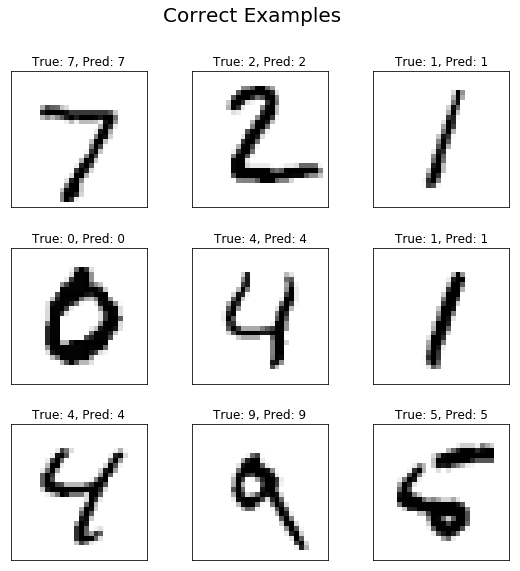

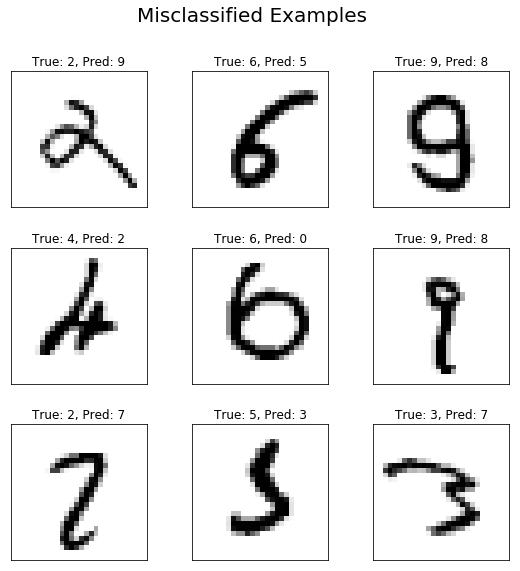

In [17]:
# Plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(y_test[:1000], axis=1)
plot_images(x_test, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(x_test[:1000], cls_true, cls_pred, title='Misclassified Examples')
plt.show()

After we finished, we have to close the __`session`__ to free the memory. We could have also used:
```python
with tf.Session as sess:
    ...
```

Please check our [Graph_and_Session](https://github.com/easy-tensorflow/easy-tensorflow/blob/master/1_TensorFlow_Basics/Tutorials/1_Graph_and_Session.ipynb) tutorial if you do not know the differences between these two implementations.
            

In [18]:
sess.close()

Thanks for reading! If you have any question or doubt, feel free to leave a comment in our [website](http://easy-tensorflow.com/).